## Graph Neural Networks

We now use Tensorflow to classify nodes in a graph using Graph Convolution Networks.

First, install gcn on your machine using the 'python setup.py install' command.

# Exercise for semisupervised classification on citation networks

In [2]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
#flags.DEFINE_float('learning_rate', 0.1, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
#flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
#flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 100, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

In [3]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

#--------------- Your code here --------------#

def masked_mean_square_error(preds,labels,mask):
    """L2 loss with masking."""
    loss = tf.nn.l2_loss(preds - labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)


#--------------------------------------------#

def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [4]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [5]:
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)
#    adj_square = np.power(adj,2).tocoo()
#    return sparse_to_tuple(adj)


In [6]:
# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

In [7]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95399 train_acc= 0.07143 val_loss= 1.95070 val_acc= 0.20600 time= 0.04338
Epoch: 0002 train_loss= 1.94801 train_acc= 0.29286 val_loss= 1.94716 val_acc= 0.37000 time= 0.01510
Epoch: 0003 train_loss= 1.94218 train_acc= 0.48571 val_loss= 1.94333 val_acc= 0.47000 time= 0.01628
Epoch: 0004 train_loss= 1.93654 train_acc= 0.56429 val_loss= 1.93922 val_acc= 0.50400 time= 0.01638
Epoch: 0005 train_loss= 1.92665 train_acc= 0.66429 val_loss= 1.93517 val_acc= 0.50400 time= 0.01611
Epoch: 0006 train_loss= 1.92017 train_acc= 0.70000 val_loss= 1.93110 val_acc= 0.51400 time= 0.01516
Epoch: 0007 train_loss= 1.91050 train_acc= 0.71429 val_loss= 1.92704 val_acc= 0.52000 time= 0.01446
Epoch: 0008 train_loss= 1.89941 train_acc= 0.71429 val_loss= 1.92310 val_acc= 0.51600 time= 0.01606
Epoch: 0009 train_loss= 1.89015 train_acc= 0.75714 val_loss= 1.91920 val_acc= 0.52000 time= 0.01525
Epoch: 0010 train_loss= 1.88369 train_acc= 0.67143 val_loss= 1.91527 val_acc= 0.52000 time= 0.01476


Epoch: 0091 train_loss= 0.92480 train_acc= 0.95000 val_loss= 1.32596 val_acc= 0.78000 time= 0.01637
Epoch: 0092 train_loss= 0.95817 train_acc= 0.92143 val_loss= 1.32011 val_acc= 0.78000 time= 0.01702
Epoch: 0093 train_loss= 0.89500 train_acc= 0.95000 val_loss= 1.31456 val_acc= 0.77800 time= 0.01809
Epoch: 0094 train_loss= 0.86474 train_acc= 0.92857 val_loss= 1.30937 val_acc= 0.77800 time= 0.01959
Epoch: 0095 train_loss= 0.90715 train_acc= 0.96429 val_loss= 1.30445 val_acc= 0.78000 time= 0.02029
Epoch: 0096 train_loss= 0.89772 train_acc= 0.93571 val_loss= 1.29963 val_acc= 0.78000 time= 0.02050
Epoch: 0097 train_loss= 0.88455 train_acc= 0.93571 val_loss= 1.29490 val_acc= 0.78000 time= 0.01729
Epoch: 0098 train_loss= 0.93267 train_acc= 0.91429 val_loss= 1.29068 val_acc= 0.78000 time= 0.01690
Epoch: 0099 train_loss= 0.88896 train_acc= 0.94286 val_loss= 1.28639 val_acc= 0.78400 time= 0.01685
Epoch: 0100 train_loss= 0.90960 train_acc= 0.91429 val_loss= 1.28227 val_acc= 0.78400 time= 0.01820


Epoch: 0180 train_loss= 0.69479 train_acc= 0.93571 val_loss= 1.07661 val_acc= 0.78200 time= 0.01681
Epoch: 0181 train_loss= 0.62900 train_acc= 0.97857 val_loss= 1.07482 val_acc= 0.78600 time= 0.01717
Epoch: 0182 train_loss= 0.64596 train_acc= 0.92857 val_loss= 1.07334 val_acc= 0.78600 time= 0.02028
Epoch: 0183 train_loss= 0.59649 train_acc= 0.97857 val_loss= 1.07162 val_acc= 0.78400 time= 0.01497
Epoch: 0184 train_loss= 0.64177 train_acc= 0.96429 val_loss= 1.07015 val_acc= 0.78400 time= 0.01512
Epoch: 0185 train_loss= 0.61356 train_acc= 0.96429 val_loss= 1.06902 val_acc= 0.78400 time= 0.01592
Epoch: 0186 train_loss= 0.64748 train_acc= 0.95000 val_loss= 1.06780 val_acc= 0.78600 time= 0.01458
Epoch: 0187 train_loss= 0.63458 train_acc= 0.96429 val_loss= 1.06619 val_acc= 0.78800 time= 0.01637
Epoch: 0188 train_loss= 0.60758 train_acc= 0.97143 val_loss= 1.06476 val_acc= 0.78800 time= 0.01506
Epoch: 0189 train_loss= 0.63303 train_acc= 0.95714 val_loss= 1.06355 val_acc= 0.78800 time= 0.01516


In [8]:
# Testing
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

Test set results: cost= 1.01263 accuracy= 0.81400 time= 0.00880


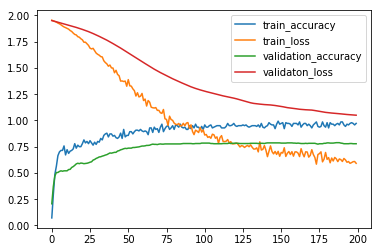

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.show()

# 1. With no weight decay / dropout  (covered in class)

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **without weight decay and without dropout**.

In [10]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += tf.nn.l2_loss(var) # no decay

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=False,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=False,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [11]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    # feed_dict.update({placeholders['dropout']: FLAGS.dropout}) no dropout

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95414 train_acc= 0.13571 val_loss= 1.94961 val_acc= 0.33000 time= 0.06132
Epoch: 0002 train_loss= 1.94643 train_acc= 0.57143 val_loss= 1.94491 val_acc= 0.40800 time= 0.02110
Epoch: 0003 train_loss= 1.93817 train_acc= 0.67857 val_loss= 1.94026 val_acc= 0.41800 time= 0.01844
Epoch: 0004 train_loss= 1.92958 train_acc= 0.68571 val_loss= 1.93589 val_acc= 0.43400 time= 0.01854
Epoch: 0005 train_loss= 1.92087 train_acc= 0.69286 val_loss= 1.93165 val_acc= 0.44600 time= 0.01781
Epoch: 0006 train_loss= 1.91195 train_acc= 0.71429 val_loss= 1.92752 val_acc= 0.46400 time= 0.01764
Epoch: 0007 train_loss= 1.90281 train_acc= 0.73571 val_loss= 1.92348 val_acc= 0.49000 time= 0.01773
Epoch: 0008 train_loss= 1.89349 train_acc= 0.75714 val_loss= 1.91946 val_acc= 0.50000 time= 0.01920
Epoch: 0009 train_loss= 1.88393 train_acc= 0.77143 val_loss= 1.91541 val_acc= 0.53000 time= 0.01871
Epoch: 0010 train_loss= 1.87410 train_acc= 0.77143 val_loss= 1.91131 val_acc= 0.53400 time= 0.01902


Epoch: 0090 train_loss= 0.82906 train_acc= 0.98571 val_loss= 1.36556 val_acc= 0.79000 time= 0.01839
Epoch: 0091 train_loss= 0.82173 train_acc= 0.98571 val_loss= 1.35981 val_acc= 0.79000 time= 0.02038
Epoch: 0092 train_loss= 0.81456 train_acc= 0.98571 val_loss= 1.35422 val_acc= 0.79200 time= 0.02416
Epoch: 0093 train_loss= 0.80753 train_acc= 0.98571 val_loss= 1.34880 val_acc= 0.78800 time= 0.01938
Epoch: 0094 train_loss= 0.80066 train_acc= 0.98571 val_loss= 1.34343 val_acc= 0.78800 time= 0.01950
Epoch: 0095 train_loss= 0.79393 train_acc= 0.98571 val_loss= 1.33808 val_acc= 0.78800 time= 0.01818
Epoch: 0096 train_loss= 0.78734 train_acc= 0.98571 val_loss= 1.33267 val_acc= 0.78800 time= 0.01806
Epoch: 0097 train_loss= 0.78090 train_acc= 0.98571 val_loss= 1.32745 val_acc= 0.78800 time= 0.01740
Epoch: 0098 train_loss= 0.77459 train_acc= 0.98571 val_loss= 1.32239 val_acc= 0.78600 time= 0.01806
Epoch: 0099 train_loss= 0.76840 train_acc= 0.98571 val_loss= 1.31729 val_acc= 0.78600 time= 0.01810


Epoch: 0179 train_loss= 0.50136 train_acc= 1.00000 val_loss= 1.08417 val_acc= 0.79000 time= 0.02262
Epoch: 0180 train_loss= 0.49951 train_acc= 1.00000 val_loss= 1.08247 val_acc= 0.79000 time= 0.03207
Epoch: 0181 train_loss= 0.49766 train_acc= 1.00000 val_loss= 1.08092 val_acc= 0.79000 time= 0.03291
Epoch: 0182 train_loss= 0.49586 train_acc= 1.00000 val_loss= 1.07936 val_acc= 0.79000 time= 0.01954
Epoch: 0183 train_loss= 0.49406 train_acc= 1.00000 val_loss= 1.07767 val_acc= 0.78800 time= 0.01825
Epoch: 0184 train_loss= 0.49227 train_acc= 1.00000 val_loss= 1.07587 val_acc= 0.78800 time= 0.01751
Epoch: 0185 train_loss= 0.49052 train_acc= 1.00000 val_loss= 1.07432 val_acc= 0.78800 time= 0.01793
Epoch: 0186 train_loss= 0.48877 train_acc= 1.00000 val_loss= 1.07302 val_acc= 0.78800 time= 0.01835
Epoch: 0187 train_loss= 0.48704 train_acc= 1.00000 val_loss= 1.07180 val_acc= 0.78800 time= 0.01742
Epoch: 0188 train_loss= 0.48533 train_acc= 1.00000 val_loss= 1.07019 val_acc= 0.78800 time= 0.02002


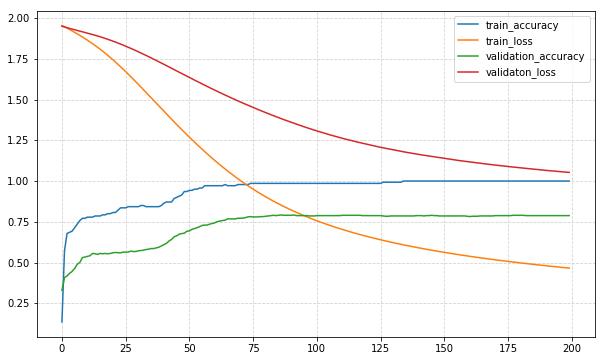

In [12]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# 2. Change it to $A^2$ (covered in class)

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **after changing the adjacency matrix to $A^2$ **.

In [13]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)
    
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    
    adj_square = normalize_adj(np.power(adj, 2).tocoo())
    
    return sparse_to_tuple(adj_square)



In [14]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95374 train_acc= 0.12143 val_loss= 1.95021 val_acc= 0.21600 time= 0.03523
Epoch: 0002 train_loss= 1.94714 train_acc= 0.30000 val_loss= 1.94647 val_acc= 0.27800 time= 0.02052
Epoch: 0003 train_loss= 1.93967 train_acc= 0.41429 val_loss= 1.94247 val_acc= 0.30800 time= 0.01585
Epoch: 0004 train_loss= 1.93359 train_acc= 0.47143 val_loss= 1.93844 val_acc= 0.31600 time= 0.01496
Epoch: 0005 train_loss= 1.92555 train_acc= 0.43571 val_loss= 1.93449 val_acc= 0.32600 time= 0.01462
Epoch: 0006 train_loss= 1.91714 train_acc= 0.57143 val_loss= 1.93064 val_acc= 0.32400 time= 0.01533
Epoch: 0007 train_loss= 1.91050 train_acc= 0.54286 val_loss= 1.92687 val_acc= 0.32800 time= 0.01492
Epoch: 0008 train_loss= 1.90186 train_acc= 0.51429 val_loss= 1.92333 val_acc= 0.33000 time= 0.01591
Epoch: 0009 train_loss= 1.89511 train_acc= 0.55000 val_loss= 1.91981 val_acc= 0.33200 time= 0.01525
Epoch: 0010 train_loss= 1.88445 train_acc= 0.55000 val_loss= 1.91620 val_acc= 0.33800 time= 0.01442


Epoch: 0092 train_loss= 0.98308 train_acc= 0.92143 val_loss= 1.38241 val_acc= 0.77400 time= 0.01660
Epoch: 0093 train_loss= 0.95656 train_acc= 0.90714 val_loss= 1.37738 val_acc= 0.77600 time= 0.01679
Epoch: 0094 train_loss= 0.99934 train_acc= 0.90000 val_loss= 1.37182 val_acc= 0.77600 time= 0.01824
Epoch: 0095 train_loss= 0.92877 train_acc= 0.94286 val_loss= 1.36574 val_acc= 0.77600 time= 0.02000
Epoch: 0096 train_loss= 0.97150 train_acc= 0.92143 val_loss= 1.35912 val_acc= 0.77600 time= 0.01519
Epoch: 0097 train_loss= 0.95690 train_acc= 0.94286 val_loss= 1.35278 val_acc= 0.78000 time= 0.01509
Epoch: 0098 train_loss= 0.93251 train_acc= 0.96429 val_loss= 1.34663 val_acc= 0.78200 time= 0.01545
Epoch: 0099 train_loss= 0.96074 train_acc= 0.91429 val_loss= 1.34089 val_acc= 0.78000 time= 0.01596
Epoch: 0100 train_loss= 0.96562 train_acc= 0.91429 val_loss= 1.33518 val_acc= 0.78000 time= 0.01548
Epoch: 0101 train_loss= 0.94124 train_acc= 0.91429 val_loss= 1.32949 val_acc= 0.78200 time= 0.01473


Epoch: 0183 train_loss= 0.68337 train_acc= 0.94286 val_loss= 1.09924 val_acc= 0.78800 time= 0.01799
Epoch: 0184 train_loss= 0.63728 train_acc= 0.97857 val_loss= 1.09751 val_acc= 0.78800 time= 0.02030
Epoch: 0185 train_loss= 0.64961 train_acc= 0.97857 val_loss= 1.09588 val_acc= 0.78800 time= 0.01729
Epoch: 0186 train_loss= 0.64549 train_acc= 0.94286 val_loss= 1.09417 val_acc= 0.78800 time= 0.01638
Epoch: 0187 train_loss= 0.64605 train_acc= 0.95000 val_loss= 1.09278 val_acc= 0.78800 time= 0.01805
Epoch: 0188 train_loss= 0.64983 train_acc= 0.95714 val_loss= 1.09060 val_acc= 0.78800 time= 0.01783
Epoch: 0189 train_loss= 0.66401 train_acc= 0.92857 val_loss= 1.08828 val_acc= 0.78800 time= 0.01715
Epoch: 0190 train_loss= 0.64238 train_acc= 0.95000 val_loss= 1.08638 val_acc= 0.78800 time= 0.01659
Epoch: 0191 train_loss= 0.65902 train_acc= 0.94286 val_loss= 1.08462 val_acc= 0.78800 time= 0.01862
Epoch: 0192 train_loss= 0.66448 train_acc= 0.94286 val_loss= 1.08303 val_acc= 0.78800 time= 0.01713


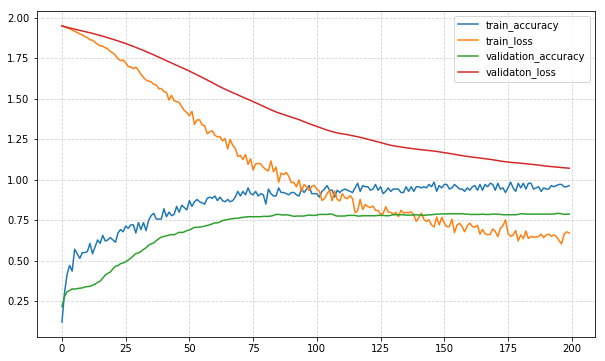

In [15]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# 3. Change to the $L_2$ loss

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **with the loss function being $L_2$ loss**.

In [16]:
#--------------- Your code here --------------#
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Mean Square error
        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
                                              self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)

#--------------------------------------------#

In [17]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95390 train_acc= 0.11429 val_loss= 1.95077 val_acc= 0.21800 time= 0.03380
Epoch: 0002 train_loss= 1.94795 train_acc= 0.30714 val_loss= 1.94714 val_acc= 0.34000 time= 0.02148
Epoch: 0003 train_loss= 1.94254 train_acc= 0.49286 val_loss= 1.94364 val_acc= 0.44400 time= 0.01655
Epoch: 0004 train_loss= 1.93584 train_acc= 0.55000 val_loss= 1.94007 val_acc= 0.48000 time= 0.01587
Epoch: 0005 train_loss= 1.92842 train_acc= 0.70714 val_loss= 1.93678 val_acc= 0.46400 time= 0.01597
Epoch: 0006 train_loss= 1.92033 train_acc= 0.69286 val_loss= 1.93408 val_acc= 0.44200 time= 0.01617
Epoch: 0007 train_loss= 1.91348 train_acc= 0.70000 val_loss= 1.93158 val_acc= 0.43800 time= 0.01652
Epoch: 0008 train_loss= 1.90294 train_acc= 0.69286 val_loss= 1.92909 val_acc= 0.44000 time= 0.01563
Epoch: 0009 train_loss= 1.89740 train_acc= 0.72143 val_loss= 1.92645 val_acc= 0.44400 time= 0.01645
Epoch: 0010 train_loss= 1.88986 train_acc= 0.70000 val_loss= 1.92389 val_acc= 0.45800 time= 0.01558


Epoch: 0092 train_loss= 0.94453 train_acc= 0.95714 val_loss= 1.41559 val_acc= 0.76000 time= 0.01610
Epoch: 0093 train_loss= 0.92437 train_acc= 0.95714 val_loss= 1.40951 val_acc= 0.76000 time= 0.01742
Epoch: 0094 train_loss= 0.98075 train_acc= 0.91429 val_loss= 1.40346 val_acc= 0.76000 time= 0.02141
Epoch: 0095 train_loss= 0.92105 train_acc= 0.95000 val_loss= 1.39684 val_acc= 0.76400 time= 0.01675
Epoch: 0096 train_loss= 0.98349 train_acc= 0.90714 val_loss= 1.38993 val_acc= 0.76800 time= 0.01470
Epoch: 0097 train_loss= 0.96032 train_acc= 0.94286 val_loss= 1.38306 val_acc= 0.77000 time= 0.01464
Epoch: 0098 train_loss= 0.91606 train_acc= 0.96429 val_loss= 1.37672 val_acc= 0.77000 time= 0.01481
Epoch: 0099 train_loss= 0.89275 train_acc= 0.92857 val_loss= 1.37095 val_acc= 0.77200 time= 0.01511
Epoch: 0100 train_loss= 0.89623 train_acc= 0.90714 val_loss= 1.36549 val_acc= 0.77200 time= 0.01455
Epoch: 0101 train_loss= 0.90687 train_acc= 0.93571 val_loss= 1.35990 val_acc= 0.77200 time= 0.01476


Epoch: 0174 train_loss= 0.71960 train_acc= 0.95000 val_loss= 1.14227 val_acc= 0.78800 time= 0.01436
Epoch: 0175 train_loss= 0.62134 train_acc= 0.97857 val_loss= 1.14299 val_acc= 0.79000 time= 0.01872
Epoch: 0176 train_loss= 0.66216 train_acc= 0.97143 val_loss= 1.14303 val_acc= 0.78800 time= 0.01960
Epoch: 0177 train_loss= 0.61580 train_acc= 0.97857 val_loss= 1.14261 val_acc= 0.78400 time= 0.01647
Epoch: 0178 train_loss= 0.73180 train_acc= 0.94286 val_loss= 1.14168 val_acc= 0.78400 time= 0.01583
Epoch: 0179 train_loss= 0.68138 train_acc= 0.95000 val_loss= 1.14072 val_acc= 0.78400 time= 0.01475
Epoch: 0180 train_loss= 0.67901 train_acc= 0.94286 val_loss= 1.13904 val_acc= 0.78200 time= 0.01489
Epoch: 0181 train_loss= 0.63896 train_acc= 0.97143 val_loss= 1.13784 val_acc= 0.78200 time= 0.01474
Epoch: 0182 train_loss= 0.65478 train_acc= 0.97143 val_loss= 1.13623 val_acc= 0.78200 time= 0.01513
Epoch: 0183 train_loss= 0.61134 train_acc= 0.97143 val_loss= 1.13451 val_acc= 0.78400 time= 0.01466


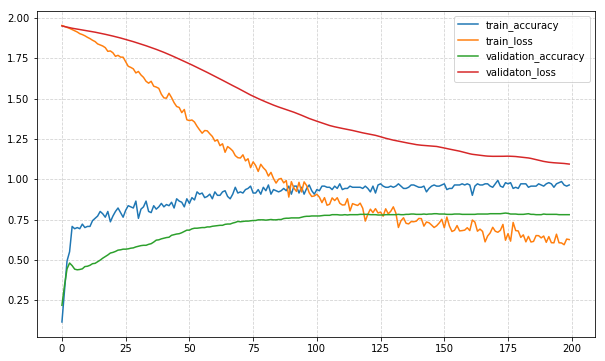

In [18]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# 4. Change the input graph/label

Now, create the input graphs using a Stochastic Block Model. The number of nodes should be 500, and then feed the true labels using $20%$ of the nodes. The degree of a node must be used as the feature.
Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps for this input graph.

In order to use your own data, you have to provide 
* an N by N adjacency matrix (N is the number of nodes), 
* an N by D feature matrix (D is the number of features per node), and
* an N by E binary label matrix (E is the number of classes).

Here, we have $500 * 500$ adjacency matrix, $500 * 1$ feature matrix and $500 * 2$ label matrix.

In [19]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)
#    adj_square = np.power(adj,2).tocoo()
#    return sparse_to_tuple(adj)

In [28]:
#--------------- Your code here --------------#
import networkx as nx
import random
import scipy.sparse as sp

# Randomly generate graph with 500 nodes
G = nx.fast_gnp_random_graph(500, 0.01, seed = 123, directed = True)
adj = nx.adjacency_matrix(G)

# Generate feature matrix
features = sp.vstack(list(G.degree(G.nodes()).values()),dtype = 'float32').tolil()

# Feed labels to 20 nodes
label = []
for i in G.nodes():
    if G.degree(i) > 10:
        label.append([1, 0])
    else: label.append([0, 1])
        
alabel = np.array(label, dtype='float64')

idx_train = range(20)
idx_val = range(20, 20 + 100)

y_train = np.zeros([500, 2])
train_mask = np.zeros([500, ], dtype = 'bool')
for i in idx_train:
    y_train[i] = alabel[i]
    train_mask[i] = True

y_val = np.zeros([500, 2])
val_mask = np.zeros([500, ], dtype = 'bool')
for i in idx_val:
    y_val[i] = alabel[i]
    val_mask[i] = True

#--------------------------------------------#

In [29]:
# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

In [30]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 0.91601 train_acc= 0.45000 val_loss= 0.74977 val_acc= 0.43000 time= 0.03799
Epoch: 0002 train_loss= 0.79998 train_acc= 0.50000 val_loss= 0.73657 val_acc= 0.43000 time= 0.00327
Epoch: 0003 train_loss= 0.78451 train_acc= 0.45000 val_loss= 0.72486 val_acc= 0.43000 time= 0.00423
Epoch: 0004 train_loss= 0.77579 train_acc= 0.40000 val_loss= 0.71418 val_acc= 0.43000 time= 0.00365
Epoch: 0005 train_loss= 0.83912 train_acc= 0.40000 val_loss= 0.70537 val_acc= 0.43000 time= 0.00322
Epoch: 0006 train_loss= 0.69573 train_acc= 0.65000 val_loss= 0.69874 val_acc= 0.43000 time= 0.00313
Epoch: 0007 train_loss= 0.66469 train_acc= 0.70000 val_loss= 0.69454 val_acc= 0.43000 time= 0.00420
Epoch: 0008 train_loss= 0.66631 train_acc= 0.70000 val_loss= 0.69300 val_acc= 0.57000 time= 0.00371
Epoch: 0009 train_loss= 0.71906 train_acc= 0.40000 val_loss= 0.69419 val_acc= 0.57000 time= 0.00334
Epoch: 0010 train_loss= 0.67461 train_acc= 0.45000 val_loss= 0.69776 val_acc= 0.57000 time= 0.00399


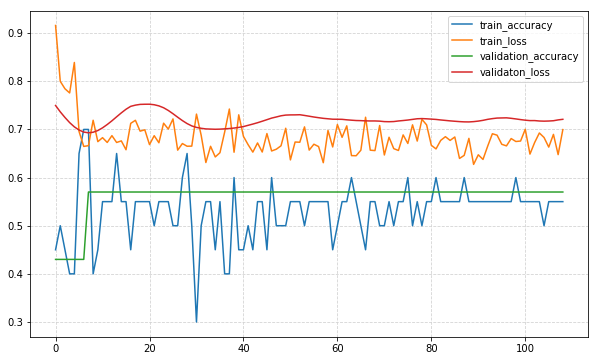

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()